# Context Classifier for Point Cloud Data 
# Uses [Pydriver](https://github.com/lpltk/pydriver) library


In [1]:
import pydriver
import numpy as np 
import sklearn, sklearn.cluster, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, precision_recall_curve,  classification_report
import pandas as pd
import copy, datetime 
import itertools
from random import shuffle,random
from collections import Counter
import time
import glob, os

/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/testing/"
label_path ='/mnt/storage/home/ja17618/scratch/models/research/deeplab/datasets/labels.csv'
f_lidar = glob.glob(os.path.join(path, 'velodyne', '*.bin'))
f_rgb = glob.glob(os.path.join(path, 'image_2', '*.png'))
f_labels = glob.glob(os.path.join(path, 'label_2', '*.txt'))
data_tag = [name.split('/')[-1].split('.')[-2] for name in f_lidar]
files=[tag+".bin" for tag in data_tag]

In [3]:
# point cloud coloring (False: reflectance, True: camera)
USE_IMAGE_COLOR = False
reader = pydriver.datasets.kitti.KITTIObjectsReader(path)
reconstructor = pydriver.preprocessing.LidarReconstructor(
    useImageColor=USE_IMAGE_COLOR,
    removeInvisible=True,
    )
# mandatory ground truth categories
DETECTION_CATEGORIES = ['car','van', 'truck', 'pedestrian', 'person_sitting', 'cyclist','tram']
# optional ground truth categories
DETECTION_CATEGORIES_OPT = ['misc', 'dontcare']

MIN_OVERLAP = 0.7               # minimal overlap between 2D boxes
EVALUATION_MODE = 'hard'    # mode (easy, moderate, hard)
VISUALIZE3D = False  

In [4]:
SHOT_RADIUS = 2.0
preprocessor = pydriver.preprocessing.Preprocessor(reconstructor)
keypointExtractor = pydriver.keypoints.ISSExtractor(salientRadius=0.25, nonMaxRadius=0.25)
featureExtractor = pydriver.features.SHOTColorExtractor(shotRadius=SHOT_RADIUS, fixedY=-1.0)
featureTypes = [('myfeature', featureExtractor.dims),]


In [5]:
# function the vocabularies will use to create category storages
def storageGenerator(dims, category):
    sto = pydriver.detectors.vocabularies.Storage(dims, category,
        preprocessors=[],
        regressor=sklearn.neighbors.KNeighborsRegressor(n_neighbors=1),
        )
    return sto
# function the detector will use to create vocabularies
def vocabularyGenerator(dimensions, featureName):

    voc = pydriver.detectors.vocabularies.Vocabulary(
        dimensions,
        preprocessors=[
            sklearn.cluster.MiniBatchKMeans(n_clusters=50, batch_size=10),#, max_iter=100),
            ],
        classifier=sklearn.ensemble.AdaBoostClassifier(n_estimators=120),
        storageGenerator=storageGenerator,
        balanceNegatives=True,
        )
    return voc

In [6]:
# initialize detector that will perform learning and recognition
detector = pydriver.detectors.Detector(featureTypes, vocabularyGenerator=vocabularyGenerator)
detector=detector.load('working_model')

In [7]:
context_df = pd.read_csv(label_path,dtype={'frame': np.int32, 'context': np.str},names=['frame','context'],header=0,index_col=False)
# context_df['frame']=context_df['frame'].apply(lambda x: '{0:0>6}'.format(x))

# context_df = pd.read_csv(label_path,index_col=False,header=0)
def get_training_frames(num=1000,shuf=0):
    urban = context_df.loc[context_df['context']=='urban','frame'].sample(n=num)
    non_urban = context_df.loc[context_df['context']=='non-urban','frame'].sample(n=num)
    ret = [x for x in itertools.chain.from_iterable(itertools.zip_longest(urban,non_urban)) if x]
    if shuf:
        return shuffle(ret)
    else:
        return ret
def get_testing_frames():
    
    num=411
    n=round(num/2)
    urban = context_df.loc[context_df['context']=='urban','frame'].sample(n=n)
    non_urban = context_df.loc[context_df['context']=='non-urban','frame'].sample(n=n)
    ret = [x for x in itertools.chain.from_iterable(itertools.zip_longest(urban,non_urban)) if x]
   

    return ret
    
    
def original_context(frame):
    c_df = context_df[context_df['frame']==frame]
    return str(c_df['context'].values[0]).lower()


In [31]:
def save_csv():
   #Function to export csv for equal urban and non-urban images
    urban = context_df.loc[context_df['context']=='urban','frame']
    non_urban = context_df.loc[context_df['context']=='non-urban','frame']
    print(urban.size + non_urban.size)
    urban= urban.sample(n=non_urban.size)
    urban.to_csv('urban.txt',index=False)
    non_urban.to_csv('non_urban.txt',index=False)
# 
# save_csv()

In [148]:
def train():
    # '''
    # Current implementation uses the pydriver library for training. 
    # See documentation on https://lpltk.github.io/pydriver/reference.html to create your own dataset class. 
    # '''
    timeStart = datetime.datetime.now()
    cnt=0
    passed=0
    for frame in get_training_frames(150): 

        frame = reader.getFrameInfo(frame)
        print('Training on frame %d...' % frame['frameId'])
        scene = preprocessor.process(frame)
        keypointCloud = keypointExtractor.getKeypointCloud(scene)
        fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
    #     print(fkeypoints)
        groundTruth, groundTruthOpt = pydriver.datasets.kitti.getKITTIGroundTruth(
            frame['labels'],
            DETECTION_CATEGORIES,
            DETECTION_CATEGORIES_OPT,
            mode='hard',    # use moderate mode for training
            )
        category = original_context(frame['frameId'])
        boxes3D_exclude = []


        for label in groundTruth + groundTruthOpt:
            box3D = pydriver.geometry.transform3DBox(label['box3D'], scene['transformation'])
            # avoid training with non-negative examples
            # the box is made bigger so SHOT features used as negatives
            # don't capture parts of the object

            if category == 'urban':

                # get keypoints which lie inside the labeled object box
                boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
                # extract features at these keypoints (and get new keypoints
                # which depend on the feature extractor)
                fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
                    # learn new features and relations between features and objects
                detector.addWords(category, 'myfeature', features, fkeypoints,box3D)

            if category == 'non-urban':
            # get keypoints which lie inside the labeled object box

                boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
                fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
                detector.addWords('negative', 'myfeature', features,fkeypoints,box3D)

    print("passed: %d" %passed)            
    timeTraining = datetime.datetime.now() - timeStart 
    # perform learning on stored data
    print('Learning...')
    timeStart = datetime.datetime.now()
    detector.learn(nStorageMaxRandomSamples=25000)
    timeLearning = datetime.datetime.now() - timeStart


Training on frame 431...
Training on frame 1185...
Training on frame 2803...
Training on frame 1360...
Training on frame 4147...
Training on frame 5756...
Training on frame 5353...
Training on frame 4464...
Training on frame 4543...
Training on frame 1876...
Training on frame 1540...
Training on frame 80...
Training on frame 6279...
Training on frame 6550...
Training on frame 406...
Training on frame 3278...
Training on frame 6018...
Training on frame 6160...
Training on frame 3486...
Training on frame 7...
Training on frame 3026...
Training on frame 1655...
Training on frame 5265...
Training on frame 925...
Training on frame 5005...
Training on frame 4840...
Training on frame 1921...
Training on frame 2596...
Training on frame 5814...
Training on frame 1623...
Training on frame 1604...
Training on frame 7251...
Training on frame 895...
Training on frame 7479...
Training on frame 5967...
Training on frame 7341...
Training on frame 689...
Training on frame 3223...
Training on frame 6690

/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=30 should be larger than k=50. Setting it to 3*k
  init_size=init_size)
/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/ipykernel_launcher.py:118: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.


In [17]:
def predict_context(detection,risk=False):
    '''
    Predict context of given values of detections. 
    Utilises majority voting criteria. 
    When risk is true the classes are assigned a conditional risk used in calculating the posterior.
    Current implementation is hardwired and priors are obtained from training set 
    
    Params: 
    detection: list containing context features. 
    risk : Boolean to use Bayesian Decision in determining probability. 
    
    '''
    contexts = [det['category'].decode('UTF-8') for det in detection]
    c = Counter(contexts)
    cls,num = c.most_common(1)[0]
    tot = sum(c.values())
    prob = num/tot
    urban_prior = 0.55
    non_urban_prior = 0.45
    z1_ls = np.array([[0,1],[1.5,0]])
#     print(prob,cls)
    if cls=='negative':
        cls='non-urban'
        l_non_urban= prob
        l_urban = 1-prob
#         if prob<0.6:
#             cls='urban'
    else:
        l_urban = prob
        l_non_urban=1-prob

    
    if risk:
        post_urban = (z1_ls[1][0] - z1_ls[0][0]) * urban_prior * l_urban
        post_non_urban = (z1_ls[0][1] - z1_ls[1][1]) * non_urban_prior * l_non_urban
        if post_urban > post_non_urban: 
            cls = 'urban'
            prob =  l_urban
        else:
            cls = 'non-urban'
            prob = l_non_urban
#     print("post of urban is %f and non urban is %f" % (l_urban,l_non_urban))

#         prob = prob/(post_non_urban+post_urban)
    
    return cls,prob

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(1,figsize=(14,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    import time
    plt.savefig('cdpcl'+str(time.time())+'.png',dpi=300)

In [ ]:
# print(timeTraining)
# print(timeLearning)


# evaluator = pydriver.evaluation.Evaluator(minOverlap=MIN_OVERLAP, nPoints=100)
# perform testing with frames which were not used for training
firstFrame = 1000
lastFrame = firstFrame+ 10
timeStart = datetime.datetime.now()
y_pred = []
y_true = []
y_prob =[]
y_frame=[] 
time = []
class_names=['non-urban','urban']
cnt=0
for frame in get_training_frames(1029):
    
    frame = reader.getFrameInfo(frame)
#     print('Testing on frame %d...' % frame['frameId'])
    # see the training part above
    scene = preprocessor.process(frame)
    
    det_start = datetime.datetime.now()
    keypointCloud = keypointExtractor.getKeypointCloud(scene)
    # extract keypoints and features for the whole scene
    fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
    # perform recognition on extracted features
    
    detections = detector.recognize({'myfeature': (fkeypoints,features)})
    det_end = datetime.datetime.now()
    time.append(det_end - det_start)
#     print(detections)
    # convert 3D detections (NumPy array) to labels (list of
    # dictionaries) that include 2D box projections used for evaluation
    # and revert the transformation of the scene, so they have the same
    # coordinate system as the original KITTI labels
#     detections_labels = pydriver.datasets.detections2labels(
#         detections,
#         scene['transformation'].I,    # inverse matrix
#         frame['calibration']['projection_left'],
#         scene['img_left'].shape,
#         )
#     dets =get_detections(detections)
#     print(dets)
    pred,prob = predict_context(detections,risk=True)
    pred1,prob1 = predict_context(detections,risk=False)
    orig = original_context(frame['frameId'])
#     print('Original prediction is %s:%f  vs risk compensated prediction %s:%f matching original?%d'%(pred1,prob1, 
#                                                                                                      pred,prob,
#                                                                                                     (orig==pred)))

#     print(cls,orig)
    if pred != orig: 
        y_frame.append([frame['frameId'],pred,orig])
    y_true.append(orig)
    y_pred.append(pred)
    y_prob.append(prob)
    cnt+=1
    
    if cnt%100==0:
        print('Testing on frame %d...' % frame['frameId'])

timeEvaluation = datetime.datetime.now() - timeStart

# show evaluation results
# print("Training time: %s" % timeTraining)
# print("Learning time: %s" % timeLearning)
print("Evaluation time: %s" % timeEvaluation)



In [18]:
values = []
time  = [] 
y_pred = []
y_true = []
y_prob =[]
y_frame=[] 
cnt=0

In [19]:
for frame in get_testing_frames():
    cnt+=1
    frame = reader.getFrameInfo(frame)
    scene = preprocessor.process(frame)
    
    det_start = datetime.datetime.now()
    keypointCloud = keypointExtractor.getKeypointCloud(scene)
    # extract keypoints and features for the whole scene
    fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
    # perform recognition on extracted features
    
    detections = detector.recognize({'myfeature': (fkeypoints,features)})
    det_end = datetime.datetime.now()
    time.append(det_end - det_start)
    pred,prob = predict_context(detections,risk=True)
    orig = original_context(frame['frameId'])
    y_true.append(orig)
    y_pred.append(pred)
    y_prob.append(prob)
    f_id = '{0:0>6}'.format(frame['frameId'])
    values.append((f_id, pred))
    if cnt%100==0:
        print(cnt)

/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if sys.path[0] == '':


100
200
300
400


In [20]:
time = [t.microseconds/1000000 for t in time]
max_t = np.max(time)
min_t = np.min(time)
mean_t = np.mean(time)
median_t = np.median(time)
variance_t = np.var(time)
print("Mean detection time is %f , median is %f and the variance is %f max: %f min: %f " % (mean_t, median_t, variance_t,max_t, min_t))


Mean detection time is 0.547173 , median is 0.638045 and the variance is 0.120354 max: 0.997359 min: 0.000275 


             precision    recall  f1-score   support

  non-urban       0.52      0.45      0.48       206
      urban       0.51      0.58      0.55       206

avg / total       0.51      0.51      0.51       412

Confusion matrix, without normalization
[[ 92 114]
 [ 86 120]]


<Figure size 432x288 with 0 Axes>

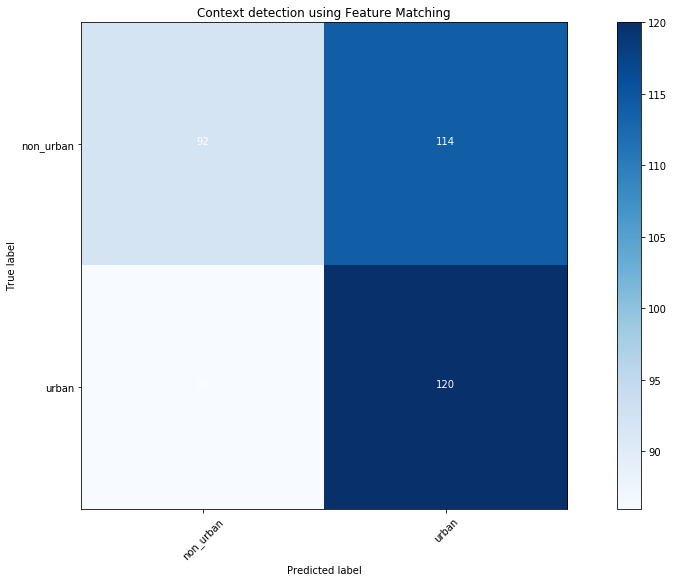

<Figure size 432x288 with 0 Axes>

In [16]:
cnf_matrix = confusion_matrix(y_true,y_pred)
class_names=['non_urban','urban']
print(classification_report(y_true,y_pred))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Context detection using Feature Matching')
# Plot normalized confusion matrix
plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')


In [ ]:
# class_names=['non-urban','urban']

cnf_matrix = confusion_matrix(y_true,y_pred)

print(classification_report(y_true,y_pred))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Context detection using Feature Matching')
# Plot normalized confusion matrix
plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')




In [ ]:
# print(set(y_true))
# print(set(y_pred))
y = [np.where(y_t == 'urban', True, False) for y_t in y_true]

avg_prec = average_precision_score(y,y_prob)
print("Average precision: %.2f" % avg_prec)

precision, recall, _ = precision_recall_curve(y, y_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          avg_prec))

In [ ]:
# incorrect_df = pd.DataFrame(y_frame,columns=['frame','predicted','original'])
# incorrect_df.to_csv("incorrect.csv",index=False)

/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


'/device:GPU:0'

Sun Aug  5 20:14:25 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.46                 Driver Version: 390.46                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   79C    P0   147W / 250W |  16056MiB / 16280MiB |     78%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:86:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |  16056MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        